## Amazon product reviews using Web Scraping & Sentimental Analysis with AI models

In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from langdetect import detect
from transformers import pipeline
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [2]:
# Ruta al archivo JSON
ruta_archivo = 'selenium_amazon_product_asin_B08PCCJP5C_reviews.json'

# Abrir el archivo JSON
with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
    datos = json.load(archivo)

df = pd.DataFrame(datos)
df.head()

,title,rating,body
0,Empresa poco seria,"1,0 de 5 estrellas","Compré el teléfono en agosto, el teléfono reco..."
1,Es un iPhone,"5,0 de 5 estrellas",Un iPhone es un iPhone. Va de lujo
2,Producto defectuoso,"1,0 de 5 estrellas",A los tres meses de comprarlo el teléfono empi...
3,Golpes con supuesta calidad excelente,"2,0 de 5 estrellas","Pedí el Iphone 12 de 64gb en Negro, técnicamen..."
4,A los seis meses deja de funcionar,"1,0 de 5 estrellas",En una actualización a los siete meses de tene...


In [3]:
# Extraer los valores numéricos utilizando expresiones regulares
df['rating'] = df['rating'].str.extract('(\d)')

# Convertir la columna 'rating' a tipo entero
df['rating'] = df['rating'].astype(int)

mapeo = {
    1: 'MUY INSATISFECHO (1/5)',
    2: 'INSATISFECHO (2/5)',
    3: 'NORMAL (3/5)',
    4: 'SATISFECHO (4/5)',
    5: 'MUY SATISFECHO (5/5)'
}
df['rating'] = df['rating'].map(mapeo)

df = df.rename(columns={'body': 'review'})

In [4]:
df.head()

,title,rating,review
0,Empresa poco seria,MUY INSATISFECHO (1/5),"Compré el teléfono en agosto, el teléfono reco..."
1,Es un iPhone,MUY SATISFECHO (5/5),Un iPhone es un iPhone. Va de lujo
2,Producto defectuoso,MUY INSATISFECHO (1/5),A los tres meses de comprarlo el teléfono empi...
3,Golpes con supuesta calidad excelente,INSATISFECHO (2/5),"Pedí el Iphone 12 de 64gb en Negro, técnicamen..."
4,A los seis meses deja de funcionar,MUY INSATISFECHO (1/5),En una actualización a los siete meses de tene...


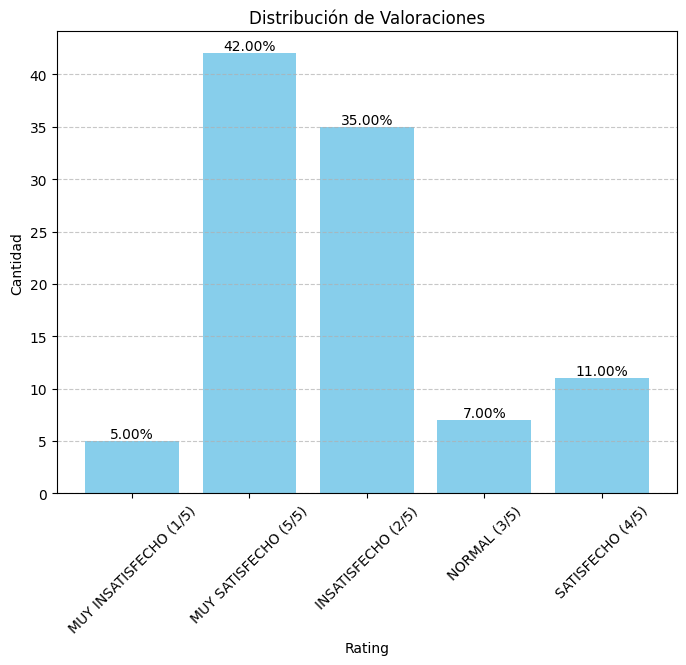

In [5]:
# Contar la frecuencia de cada categoría
conteo_rating = df['rating'].value_counts().sort_index()

# Calcular el total de valoraciones
total_valoraciones = conteo_rating.sum()

# Calcular los porcentajes
porcentajes = (conteo_rating / total_valoraciones) * 100

# Definir los nombres de las categorías
categorias = df['rating'].unique()

# Plotear el gráfico de barras
plt.figure(figsize=(8, 6))
barras = plt.bar(categorias, conteo_rating, color='skyblue')
plt.title('Distribución de Valoraciones')
plt.xlabel('Rating')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar los porcentajes en cada barra
for barra, porcentaje in zip(barras, porcentajes):
    height = barra.get_height()
    plt.text(barra.get_x() + barra.get_width() / 2, height, f'{porcentaje:.2f}%', ha='center', va='bottom')

plt.show()

In [6]:
nltk.download('punkt')

# Definir función para limpiar el texto
def limpiar_texto(texto):
    # Normalizar texto: Convertir a minúsculas
    texto = texto.lower()   
    # Tokenización: Convertir el texto en una lista de palabras (tokens)
    tokens = word_tokenize(texto)   
    # Eliminar caracteres no alfanuméricos
    tokens = [token for token in tokens if token.isalnum()]
    # Unir los tokens nuevamente en un solo string
    texto_limpio = ' '.join(tokens)
    
    return texto_limpio

# Aplicar limpieza de texto a la columna 'review'
df['review'] = df['review'].apply(limpiar_texto)

[nltk_data] Downloading package punkt to C:\Users\Antonio
[nltk_data]     Barrera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def detectar_idioma(texto):
    try:
        idioma = detect(texto)
    except:
        idioma = 'No detectado'  # En caso de que no se pueda detectar el idioma
    return idioma

# Aplicar la función detectar_idioma a la columna 'review'
df['idioma'] = df['review'].apply(detectar_idioma)

C:\Users\Antonio Barrera\AppData\Local\Temp\ipykernel_24440\520012547.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cantidad = conteo_idiomas[i]
C:\Users\Antonio Barrera\AppData\Local\Temp\ipykernel_24440\520012547.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  porcentaje = porcentaje_idiomas[i]


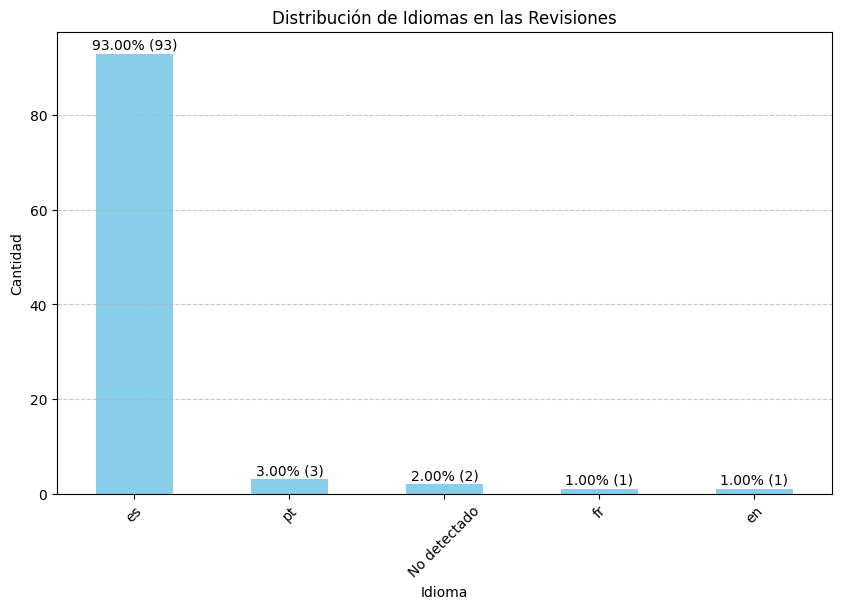

In [8]:
# # Calcular el total de revisiones
total_revisiones = df.shape[0]

# Calcular la frecuencia y el porcentaje de cada idioma
conteo_idiomas = df['idioma'].value_counts()
porcentaje_idiomas = (conteo_idiomas / total_revisiones) * 100

# Plotear el gráfico de barras
plt.figure(figsize=(10, 6))
ax = conteo_idiomas.plot(kind='bar', color='skyblue')
plt.title('Distribución de Idiomas en las Revisiones')
plt.xlabel('Idioma')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para una mejor legibilidad

# Mostrar el porcentaje y el número total de revisiones en cada barra
for i in range(len(conteo_idiomas)):
    idioma = conteo_idiomas.index[i]
    cantidad = conteo_idiomas[i]
    porcentaje = porcentaje_idiomas[i]
    ax.text(i, cantidad + 1, f'{porcentaje:.2f}% ({cantidad})', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
# Cargar el modelo de análisis de sentimientos multilingüe
analisis_sentimientos = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Definir una función para clasificar la revisión como positiva, negativa o neutra
def clasificar_sentimiento(review):
    resultado = analisis_sentimientos(review)[0]
    etiqueta = resultado['label']
    score = resultado['score']
    return etiqueta, score

# Aplicar la función de clasificación de sentimiento a la columna 'review'
df['sentimiento'] = df['review'].apply(clasificar_sentimiento)


def clasificar_sentimiento_etiqueta(star_rating):
    if '1' in star_rating:
        return 'MUY INSATISFECHO (1/5)'
    elif '2' in star_rating:
        return 'INSATISFECHO (2/5)'
    elif '3' in star_rating:
        return 'NORMAL (3/5)'
    elif '4' in star_rating:
        return 'SATISFECHO (4/5)'
    elif '5' in star_rating:
        return 'MUY SATISFECHO (5/5)'
    else:
        return 'No clasificado'

# Aplicar la función de clasificación de sentimiento a la columna 'sentimiento'
df['sentimiento_etiqueta'] = df['sentimiento'].apply(lambda x: clasificar_sentimiento_etiqueta(x[0]))

df.head()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


,title,rating,review,idioma,sentimiento,sentimiento_etiqueta
0,Empresa poco seria,MUY INSATISFECHO (1/5),compré el teléfono en agosto el teléfono recon...,es,"(1 star, 0.8183051347732544)",MUY INSATISFECHO (1/5)
1,Es un iPhone,MUY SATISFECHO (5/5),un iphone es un iphone va de lujo,fr,"(5 stars, 0.26329660415649414)",MUY SATISFECHO (5/5)
2,Producto defectuoso,MUY INSATISFECHO (1/5),a los tres meses de comprarlo el teléfono empi...,es,"(1 star, 0.8956617116928101)",MUY INSATISFECHO (1/5)
3,Golpes con supuesta calidad excelente,INSATISFECHO (2/5),pedí el iphone 12 de 64gb en negro técnicament...,es,"(3 stars, 0.46956732869148254)",NORMAL (3/5)
4,A los seis meses deja de funcionar,MUY INSATISFECHO (1/5),en una actualización a los siete meses de tene...,es,"(1 star, 0.8756709694862366)",MUY INSATISFECHO (1/5)


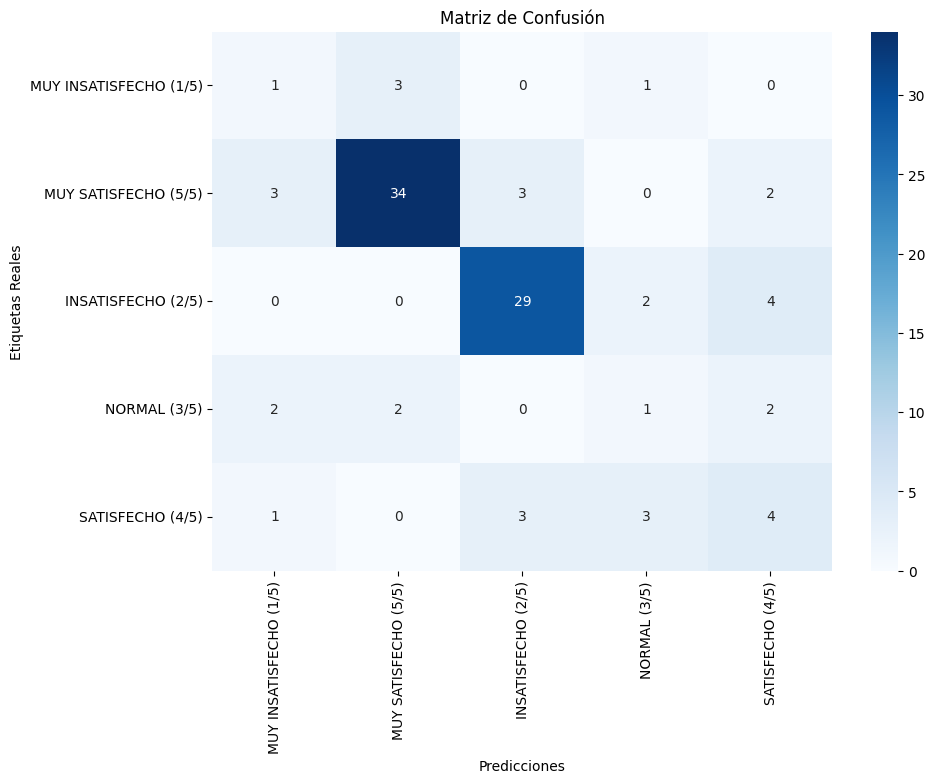

Accuracy: 69.0 %


In [10]:
# Calcula la matriz de confusión
conf_matrix = confusion_matrix(df['rating'], df['sentimiento_etiqueta'])

# Obtiene las etiquetas únicas
labels = df['rating'].unique()

# Plotear la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

# Calcula el accuracy
accuracy = accuracy_score(df['rating'], df['sentimiento_etiqueta'])
print("Accuracy:", accuracy * 100, "%")

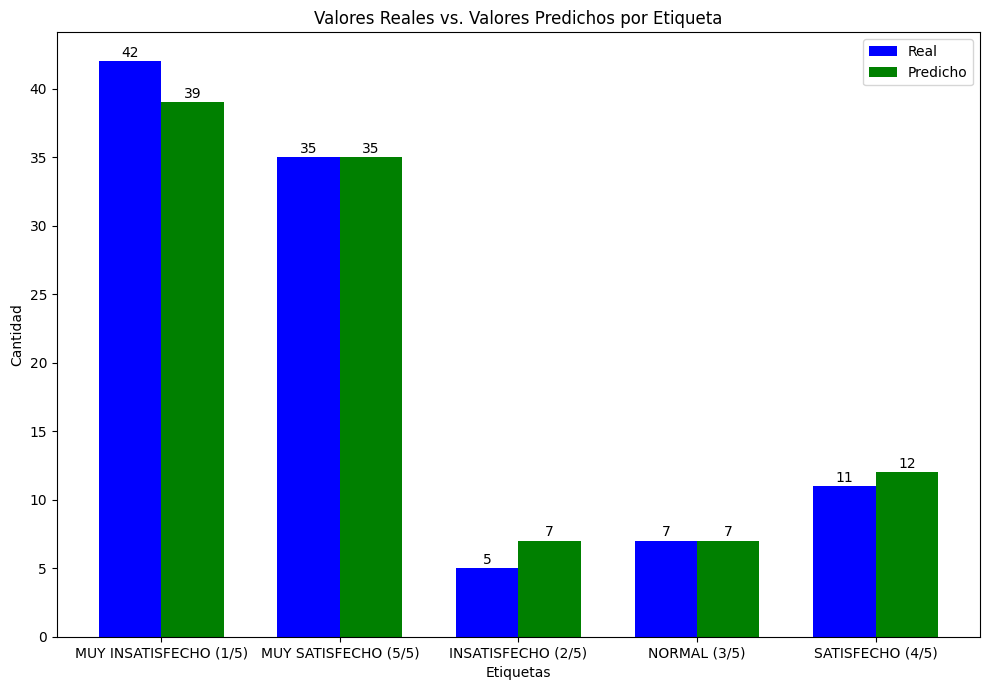

In [11]:
# Obtén las etiquetas únicas
labels = df['rating'].unique()

# Inicializa las listas para almacenar las alturas de las barras
real_values = []
predicted_values = []

# Itera sobre las etiquetas únicas y calcula la cantidad de valores reales y predichos para cada una
for label in labels:
    real_values.append(np.sum(df['rating'] == label))
    predicted_values.append(np.sum(df['sentimiento_etiqueta'] == label))

# Configura la posición de las barras
bar_width = 0.35
indices = np.arange(len(labels))

# Crea el gráfico de barras
plt.figure(figsize=(10, 7))
plt.bar(indices, real_values, bar_width, color='b', label='Real')
plt.bar(indices + bar_width, predicted_values, bar_width, color='g', label='Predicho')

# Agrega los números encima de las barras
for i, v in enumerate(real_values):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', color='black')
for i, v in enumerate(predicted_values):
    plt.text(i + bar_width, v + 0.1, str(v), ha='center', va='bottom', color='black')

# Configura los ejes y etiquetas
plt.xlabel('Etiquetas')
plt.ylabel('Cantidad')
plt.title('Valores Reales vs. Valores Predichos por Etiqueta')
plt.xticks(indices + bar_width / 2, labels)
plt.legend()

# Muestra el gráfico
plt.tight_layout()
plt.show()

Descripción del modelo de hugginface:
* Este es un modelo bert-base-multilingüe-sin mayúsculas optimizado para el análisis de sentimientos sobre reseñas de productos en seis idiomas: inglés, holandés, alemán, francés, español e italiano. Predice el sentimiento de la reseña como una cantidad de estrellas (entre 1 y 5).
* Este modelo está pensado para su uso directo como modelo de análisis de opiniones para reseñas de productos en cualquiera de los seis idiomas anteriores o para un mayor ajuste de tareas de análisis de opiniones relacionadas.

* Link hugginface: https://huggingface-co.translate.goog/nlptown/bert-base-multilingual-uncased-sentiment?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=sc

_____________

**PRÓXIMOS PASOS:**

* aplicación de otros modelos + aplicación de modelos por un único idioma 
* estudiar posibilidad de aplicar embeddings
* ampliar la muestra para mejorar el modelo y por consiguiente los resultados/predicciones + añadir reviews en otros idiomas para que se pueda aplicar el analisis sobre productos americanos, alemanes, franceses etc...